*Unit 2, Sprint 2, Module 4*

---

# Classification Metrics

- get and interpret the **confusion matrix** for classification models
- use classification metrics: **precision, recall**
- understand the relationships between precision, recall, **thresholds, and predicted probabilities**, to help **make decisions and allocate budgets**
- Get **ROC AUC** (Receiver Operating Characteristic, Area Under the Curve)

### Setup

Run the code cell below. You can work locally (follow the [local setup instructions](https://lambdaschool.github.io/ds/unit2/local/)) or on Colab.

Libraries

- category_encoders
- ipywidgets
- matplotlib
- numpy
- pandas
- scikit-learn
- seaborn

In [156]:
%%capture
import sys

# If you're on Colab:
if 'google.colab' in sys.modules:
    DATA_PATH = 'https://github.com/skhabiri/PredictiveModeling-TreeBasedModels-u2s2/tree/master/data/'
    !pip install category_encoders==2.*

# If you're working locally:
else:
    DATA_PATH = '../data/'

# Get and interpret the confusion matrix for classification models

## Overview

First, load the Tanzania Waterpumps data and fit a model. (This code isn't new, we've seen it all before.)

In [157]:
%matplotlib inline
import category_encoders as ce
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
from sklearn.impute import SimpleImputer
from sklearn.metrics import accuracy_score
from sklearn.model_selection import train_test_split
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import FunctionTransformer
from sklearn.ensemble import RandomForestClassifier

def wrangle(X):
    """Wrangles train, validate, and test sets in the same way"""
    X = X.copy()

    # Convert date_recorded to datetime
    X['date_recorded'] = pd.to_datetime(X['date_recorded'], infer_datetime_format=True)
    
    # Extract components from date_recorded, then drop the original column
    X['year_recorded'] = X['date_recorded'].dt.year
    X['month_recorded'] = X['date_recorded'].dt.month
    X['day_recorded'] = X['date_recorded'].dt.day

    X = X.drop(columns='date_recorded')
    
    # Engineer feature: how many years from construction_year to date_recorded
    X['years'] = X['year_recorded'] - X['construction_year']    
    
    # all the days since construction date
#     X['days'] = (X['year_recorded'] - X['construction_year']).dt.days 

    # Drop recorded_by (never varies) and id (always varies, random)
    unusable_variance = ['recorded_by', 'id']
    X = X.drop(columns=unusable_variance)
    
    # Drop duplicate columns
    duplicate_columns = ['quantity_group']
    X = X.drop(columns=duplicate_columns)
    
    # About 3% of the time, latitude has small values near zero,
    # outside Tanzania, so we'll treat these like null values
    X['latitude'] = X['latitude'].replace(-2e-08, np.nan)
    
    # When columns have zeros and shouldn't, they are like null values
    cols_with_zeros = ['construction_year', 'longitude', 'latitude', 'gps_height', 'population']
    for col in cols_with_zeros:
        X[col] = X[col].replace(0, np.nan)
        
    return X

In [158]:
# Merge train_features.csv & train_labels.csv
train = pd.merge(pd.read_csv(DATA_PATH+'waterpumps/train_features.csv'), 
                 pd.read_csv(DATA_PATH+'waterpumps/train_labels.csv'))

# Read test_features.csv & sample_submission.csv
test = pd.read_csv(DATA_PATH+'waterpumps/test_features.csv')
sample_submission = pd.read_csv(DATA_PATH+'waterpumps/sample_submission.csv')

# Split train into train & val. Make val the same size as test.
target = 'status_group'
train, val = train_test_split(train, test_size=len(test),  
                              stratify=train[target], random_state=42)

# Arrange data into X features matrix and y target vector
X_train = train.drop(columns=target)
y_train = train[target]
X_val = val.drop(columns=target)
y_val = val[target]
X_test = test

# Make pipeline!
"""
FunctionTransformer:
validate=boolean
If True, then X will be converted to a 2-dimensional NumPy array or
sparse matrix. If the conversion is not possible an exception is
raised.
"""
pipeline = make_pipeline(
    FunctionTransformer(wrangle, validate=False), 
    ce.OrdinalEncoder(), 
    SimpleImputer(strategy='mean'), 
    RandomForestClassifier(n_estimators=100, random_state=42, n_jobs=-1)
)

# Fit on train, score on val
pipeline.fit(X_train, y_train)
y_pred = pipeline.predict(X_val)
print('Validation Accuracy', accuracy_score(y_val, y_pred))
pipeline.score(X_val, y_val)

Validation Accuracy 0.8140409527789386


0.8140409527789386

* accuracy_score() does not need the fitted estimator. It only needs the truth label and predicted label.
* .score() is a method for the fitted estimator and needs the input to the estimator and the truth label. It returns the accuracy score.

## Follow Along

Scikit-learn added a [**`plot_confusion_matrix`**](https://scikit-learn.org/stable/modules/generated/sklearn.metrics.plot_confusion_matrix.html) function in version 0.22!

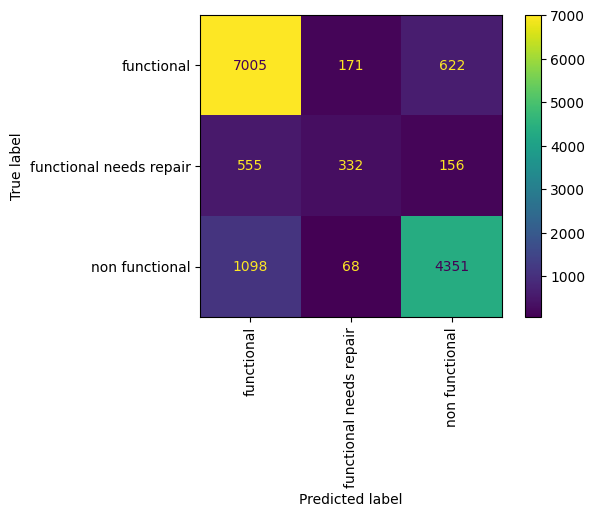

In [159]:
from sklearn.metrics import plot_confusion_matrix

plt.rcParams['figure.dpi'] = 100

plot_confusion_matrix(pipeline, X_val, y_val, values_format='.0f', xticks_rotation='vertical');

#### How many correct predictions were made?

In [160]:
correct_predictions = 7005 + 332 + 4351
correct_predictions

11688

#### How many total predictions were made?

In [161]:
total_predictions = 7005 + 171 + 622 + 555 + 332 + 156 + 1098 + 68 + 4351
total_predictions, len(X_val)

(14358, 14358)

#### What was the classification accuracy?

In [162]:
correct_predictions / total_predictions

0.8140409527789386

In [163]:
accuracy_score(y_val, y_pred)

0.8140409527789386

# Use classification metrics: precision, recall

## Overview

[Scikit-Learn User Guide — Classification Report](https://scikit-learn.org/stable/modules/model_evaluation.html#classification-report)

#### Wikipedia, [Precision and recall](https://en.wikipedia.org/wiki/Precision_and_recall)

> Both precision and recall are based on an understanding and measure of relevance.

> Suppose a computer program for recognizing dogs in photographs identifies 8 dogs in a picture containing 12 dogs and some cats. Of the 8 identified as dogs, 5 actually are dogs (true positives), while the rest are cats (false positives). The program's precision is 5/8 while its recall is 5/12.

> High precision means that an algorithm returned substantially more relevant results than irrelevant ones, while high recall means that an algorithm returned most of the relevant results.

<img src="https://upload.wikimedia.org/wikipedia/commons/thumb/2/26/Precisionrecall.svg/700px-Precisionrecall.svg.png" width="400">

- **Recall Recalling all the true positives** $Recall = \frac{TP}{TP+FN}$
- **Precision How precise are the predicted positives** $Precision = \frac{TP}{TP+FP}$
- **Acccuracy is accuracy of predictions (positive and negative) in total $Accuracy = \frac{TP+TN}{TP+TN+FP+FN}$**

## Follow Along

#### [We can get precision & recall from the confusion matrix](https://en.wikipedia.org/wiki/Precision_and_recall#Definition_(classification_context))

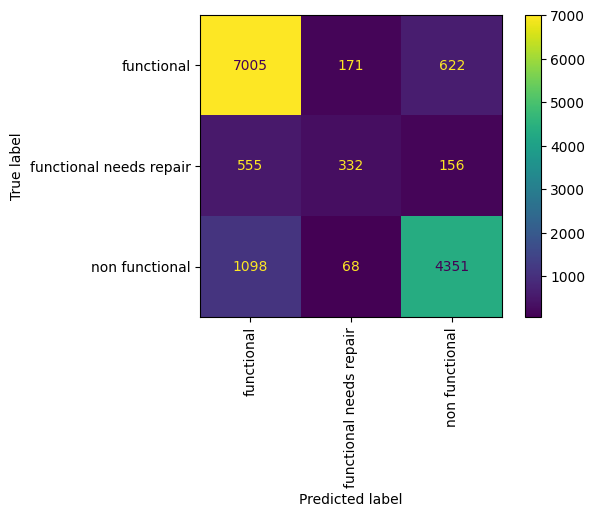

In [164]:
cm = plot_confusion_matrix(pipeline, X_val, y_val, values_format='.0f', xticks_rotation='vertical')

In [165]:
print(type(cm))
print(cm.confusion_matrix)
print(cm.display_labels)

<class 'sklearn.metrics._plot.confusion_matrix.ConfusionMatrixDisplay'>
[[7005  171  622]
 [ 555  332  156]
 [1098   68 4351]]
['functional' 'functional needs repair' 'non functional']


#### How many correct predictions of "non functional"?

In [166]:
# 4351
mask_nonfun = cm.display_labels=='non functional'
correct_predictions_nonfunctional = cm.confusion_matrix[mask_nonfun, mask_nonfun].item()
correct_predictions_nonfunctional

4351

#### How many total predictions of "non functional"?

In [167]:
#4351 + 156 + 622 = 5129
total_predictions_nonfunctional = cm.confusion_matrix[:, mask_nonfun].sum()
total_predictions_nonfunctional

5129

#### What's the precision for "non functional"?

In [168]:
correct_predictions_nonfunctional / total_predictions_nonfunctional

0.8483135114057321

In [169]:
from sklearn.metrics import classification_report
print (classification_report(y_val, y_pred))

                         precision    recall  f1-score   support

             functional       0.81      0.90      0.85      7798
functional needs repair       0.58      0.32      0.41      1043
         non functional       0.85      0.79      0.82      5517

               accuracy                           0.81     14358
              macro avg       0.75      0.67      0.69     14358
           weighted avg       0.81      0.81      0.81     14358



**f1_score reflects the worse of recall and precision**

## $$\frac{2}{f1\_score} = \frac{1}{recall} + \frac{1}{precision}$$

#### How many actual "non functional" waterpumps?

In [170]:
# 1098 + 68 + 4351 = 5517
actual_nonfunctional = cm.confusion_matrix[mask_nonfun,:].sum()
actual_nonfunctional

5517

#### What's the recall for "non functional"?

In [171]:
correct_predictions_nonfunctional / actual_nonfunctional

0.7886532535798442

# Understand the relationships between precision, recall, thresholds, and predicted probabilities, to help make decisions and allocate budgets

## Overview

### Imagine this scenario...

Suppose there are over 14,000 waterpumps that you _do_ have some information about, but you _don't_ know whether they are currently functional, or functional but need repair, or non-functional.

In [172]:
len(test)

14358

**You have the time and resources to go to just 2,000 waterpumps for proactive maintenance.** You want to predict, which 2,000 are most likely non-functional or in need of repair, to help you triage and prioritize your waterpump inspections.

You have historical inspection data for over 59,000 other waterpumps, which you'll use to fit your predictive model.

In [173]:
len(train) + len(val)

59400

Based on this historical data, if you randomly chose waterpumps to inspect, then about 46% of the waterpumps would need repairs, and 54% would not need repairs.

In [174]:
y_train.value_counts(normalize=True)

functional                 0.543071
non functional             0.384241
functional needs repair    0.072688
Name: status_group, dtype: float64

In [175]:
random_inspections = 2000
print(f'With {random_inspections} random inspections, we expect to repair {0.46*random_inspections} waterpumps')

With 2000 random inspections, we expect to repair 920.0 waterpumps


**Can you do better than random at prioritizing inspections?**

In this scenario, we should define our target differently. We want to identify which waterpumps are non-functional _or_ are functional but needs repair:

In [176]:
y_train = y_train != 'functional'
y_val = y_val != 'functional'
y_train.value_counts(normalize=True)

False    0.543071
True     0.456929
Name: status_group, dtype: float64

True label means a waterpump needs repair.
We already made our validation set the same size as our test set.

In [177]:
len(val) == len(test)

True

We can refit our model, using the redefined target.

Then make predictions for the validation set.

In [178]:
pipeline.fit(X_train, y_train)
y_pred = pipeline.predict(X_val)

/Users/shahnam/.pyenv/versions/3.7.8/lib/python3.7/site-packages/category_encoders/utils.py:21: FutureWarning: is_categorical is deprecated and will be removed in a future version.  Use is_categorical_dtype instead
  elif pd.api.types.is_categorical(cols):


In [179]:
print(accuracy_score(y_val, y_pred))
# or
pipeline.score(X_val, y_val)

0.8255328040117008


0.8255328040117008

## Follow Along

#### Look at the confusion matrix:

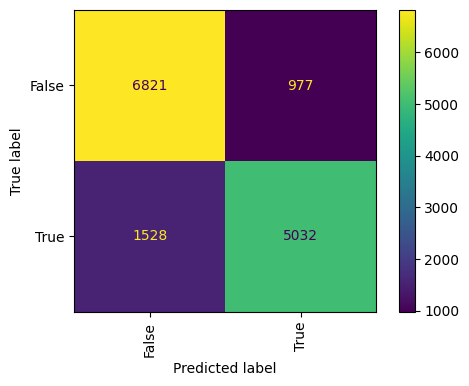

In [180]:
cm = plot_confusion_matrix(pipeline, X_val, y_val, values_format='.0f', xticks_rotation='vertical')

#### How many total predictions of "True" ("non functional" or "functional needs repair") ?

In [181]:
print(cm.display_labels)
cm.confusion_matrix[:, cm.display_labels].sum()

[False  True]


6009

In [182]:
print(classification_report(y_val, y_pred))

              precision    recall  f1-score   support

       False       0.82      0.87      0.84      7798
        True       0.84      0.77      0.80      6560

    accuracy                           0.83     14358
   macro avg       0.83      0.82      0.82     14358
weighted avg       0.83      0.83      0.82     14358



*Our precision for True label is 0.84. But we don't need 6009 predictions. We only need 2000. We improve our precision by increasing the positive threshold for predicted probability. While this lower the number of positive predictions but increases our prediction confidence.*

### We don't have "budget" to take action on all these predictions

- But we can get predicted probabilities, to rank the predictions. 
- Then change the threshold, to change the number of positive predictions, based on our budget.

***Here we care about Precision no Recall and we try to change the threshold for probalility to trade off recall for precision as we already have way more than 2000 predicted candidates***

### Get predicted probabilities and plot the distribution

In [183]:
# predicted probabilities has probability value for both classes
print(pipeline.predict_proba(X_val).shape)
pipeline.predict_proba(X_val)

(14358, 2)


array([[0.  , 1.  ],
       [0.26, 0.74],
       [0.9 , 0.1 ],
       ...,
       [0.91, 0.09],
       [0.41, 0.59],
       [0.98, 0.02]])

Getting the probabilites of True class prediction

In [184]:
pipeline.predict_proba(X_val)[:, 1]

array([1.  , 0.74, 0.1 , ..., 0.09, 0.59, 0.02])

### Change the threshold
We want to increase our prediction confidence by increasing the probability threshold of classifying it as True label

[1.   0.74 0.1  ... 0.09 0.59 0.02]


/Users/shahnam/.pyenv/versions/3.7.8/lib/python3.7/site-packages/seaborn/distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


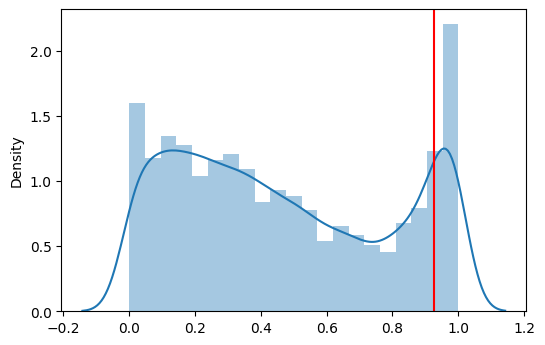

In [185]:
import seaborn as sns

threshold = 0.925
# pipeline.predict_proba(X_val)[:, 1] > threshold

y_pred_prob = pipeline.predict_proba(X_val)[:, 1]
print(y_pred_prob)

# It plots the count distribution of different probability values in a few bins
sns.distplot(y_pred_prob, norm_hist=False)
plt.axvline(threshold, color='red')

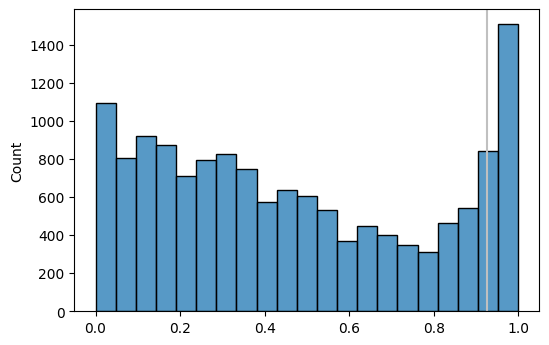

In [186]:
sns.histplot(y_pred_prob)
plt.axvline(threshold, color="silver")

Let's check if we have enough (2000) True predictions with the set threshold

In [187]:
sum(pipeline.predict_proba(X_val)[:, 1] > threshold)

2033

### Or, get exactly 2,000 positive predictions

Identify the 2,000 waterpumps in the validation set with highest predicted probabilities.

In [188]:
results = pd.DataFrame({'y_val': y_val, 'y_pred_prob': y_pred_prob})
results

,y_val,y_pred_prob
58046,True,1.00
41184,True,0.74
27587,False,0.10
53109,False,0.05
7245,True,0.55
...,...,...
18760,False,0.68
36059,True,0.88
4759,False,0.09
43621,False,0.59


Most of these top 2,000 waterpumps will be relevant recommendations, meaning `y_val==True`, meaning the waterpump is non-functional or needs repairs.

Some of these top 2,000 waterpumps will be irrelevant recommendations, meaning `y_val==False`, meaning the waterpump is functional and does not need repairs.

Let's look at a random sample of 50 out of these top 2,000:

In [189]:
top2000 = results.sort_values(by='y_pred_prob', ascending=False)[:2000]

In [202]:
top2000.tail(n=10)

,y_val,y_pred_prob
35631,True,0.93
33905,True,0.93
6751,True,0.93
32831,True,0.93
28863,False,0.93
30643,True,0.93
14010,True,0.93
22524,True,0.93
55253,True,0.93
39829,True,0.93


So how many of our recommendations were relevant? y_val is the true label. We check with the set threshold how many of the 200 trips needed repair and compare that with the baseline.

In [191]:
trips = 2000
print(f'Baseline: {trips * 0.46} waterpump repairs in {trips} trips')

relevant_recommendations = top2000['y_val'].sum()
print(f'With model: Predict {relevant_recommendations} waterpump repairs in {trips} trips')

Baseline: 920.0 waterpump repairs in 2000 trips
With model: Predict 1972 waterpump repairs in 2000 trips


What's the precision for this subset of 2,000 predictions?

In [192]:
precision_at_k_2000 = relevant_recommendations / trips
print('Precision @ k=2000', precision_at_k_2000)

Precision @ k=2000 0.986


*We improved our positive precision from 0.84 to 0.986, in return for a smaller number of positive predictions (lower recall)*

### In this scenario ... 

Accuracy _isn't_ the best metric!

Instead, change the threshold, to change the number of positive predictions, based on the budget. (You have the time and resources to go to just 2,000 waterpumps for proactive maintenance.)

Then, evaluate with the precision for "non functional"/"functional needs repair".

This is conceptually like **Precision@K**, where k=2,000.

Read more here: [Recall and Precision at k for Recommender Systems: Detailed Explanation with examples](https://medium.com/@m_n_malaeb/recall-and-precision-at-k-for-recommender-systems-618483226c54)

> Precision at k is the proportion of recommended items in the top-k set that are relevant

> Mathematically precision@k is defined as: `Precision@k = (# of recommended items @k that are relevant) / (# of recommended items @k)`

> In the context of recommendation systems we are most likely interested in recommending top-N items to the user. So it makes more sense to compute precision and recall metrics in the first N items instead of all the items. Thus the notion of precision and recall at k where k is a user definable integer that is set by the user to match the top-N recommendations objective.

We asked, can you do better than random at prioritizing inspections?

If we had randomly chosen waterpumps to inspect, we estimate that only 920 waterpumps would be repaired after 2,000 maintenance visits. (46%)

But using our predictive model, in the validation set, we succesfully identified over 1,900 waterpumps in need of repair!

So we will use this predictive model with the dataset of over 14,000 waterpumps that we _do_ have some information about, but we _don't_ know whether they are currently functional, or functional but need repair, or non-functional.

We will predict which 2,000 are most likely non-functional or in need of repair.

We estimate that approximately 1,900 waterpumps will be repaired after these 2,000 maintenance visits.

So we're confident that our predictive model will help triage and prioritize waterpump inspections.

### But ...

This metric (~1,900 waterpumps repaired after 2,000 maintenance visits) is specific for _one_ classification problem and _one_ possible trade-off.

Can we get an evaluation metric that is generic for _all_ classification problems and _all_ possible trade-offs?

Yes — the most common such metric is **ROC AUC.**

## Get ROC AUC (Receiver Operating Characteristic, Area Under the Curve)

[Wikipedia explains,](https://en.wikipedia.org/wiki/Receiver_operating_characteristic) "A receiver operating characteristic curve, or ROC curve, is a graphical plot that illustrates the diagnostic ability of a binary classifier system as its discrimination threshold is varied. **The ROC curve is created by plotting the true positive rate (TPR) against the false positive rate (FPR) at various threshold settings.**"

ROC AUC is the area under the ROC curve. [It can be interpreted](https://stats.stackexchange.com/questions/132777/what-does-auc-stand-for-and-what-is-it) as "the expectation that a uniformly drawn random positive is ranked before a uniformly drawn random negative." 

ROC AUC measures **how well a classifier ranks predicted probabilities.** So, when you get your classifier’s ROC AUC score, you need to **use predicted probabilities, not discrete predictions.**

ROC AUC ranges **from 0 to 1.** Higher is better. A naive majority class **baseline** will have an ROC AUC score of **0.5.** 

#### Scikit-Learn docs
- [User Guide: Receiver operating characteristic (ROC)](https://scikit-learn.org/stable/modules/model_evaluation.html#receiver-operating-characteristic-roc)
- [sklearn.metrics.roc_curve](https://scikit-learn.org/stable/modules/generated/sklearn.metrics.roc_curve.html)
- [sklearn.metrics.roc_auc_score](https://scikit-learn.org/stable/modules/generated/sklearn.metrics.roc_auc_score.html)

#### More links
- [ROC curves and Area Under the Curve explained](https://www.dataschool.io/roc-curves-and-auc-explained/)
- [The philosophical argument for using ROC curves](https://lukeoakdenrayner.wordpress.com/2018/01/07/the-philosophical-argument-for-using-roc-curves/)

ROC is a plot of $TPR=\frac{TP}{TP+FN}=\frac{TP}{all True Positives}$ on y axis vs $FPR=\frac{FP}{FP+TN}=\frac{FP}{all True Negatives}$ on x axis, for a binary classifier. 
- To get different values of TPR and FPR, we need to sweep probability threshold of binary classification. 
- When probability threshold for a positive prediction is 0, classifier predicts all the data as positive, in other word, $TPR=\frac{all True Positives}{all True Positives}=1$ and $FPR=\frac{all True negatives}{all True Negatives}=1$.
- When probability threshold for a positive prediction is 1, classifier predicts none of the data as positive, in other word, $TPR=\frac{0}{all True Positives}=0$ and $FPR=\frac{0}{all True Negatives}=0$.
- Assume the population of True positives and True negatives are compeletely separated with two normal distribution with negative population on the left and positive population on the right where x-axis is the probability of being classified as positive label and y axis is the density of the samples. when we increase the threshold on x-axis of the density plot, we are reducing the FP while TP remains intact (equal to total True Positives). This means we are moving on ROC curve from top right corner to the top left corner. two separate distribution allows to make FPR=0 by placing the probability threshold after all negative label population on density plot, while maintaining TPR=1, by having the threshold probability still before the start of positive label distribution. When we reduce the probability threshold of a positive classification from 1 on x-axis of probability, for two separate distribution by entrenching over positive label distribution, we are basically increasing TP prediction. If the threshold has not reached the negative class distribution yet, that means we increased the TPR while kept the FP prediction at zero. That means on ROC curve we go from bottom left to top left vertically.
- Two overlap density distribution of Positive and Negative labels fail to maintain one of the rates while changing the other one. In other words, reducing the threshold from 1, increases the TPR by adding to the TP while increases the FPR at the same time by adding to the FP. Similarly, increasing the threshold from 0, reduces the TP and hence TPR, while at the same time reduces FP and hence FPR too.

In a nut shell the question is in a binary classifier when we move the probability threshold over the distribution plot of one class, how does the threshold overlay the distribution of the other class. If we can place the threshold such to separate both classes that is AUC of 1 an it's an ideal binary classifier. If both distribution overlay eachother, the AUC is 0.5 and it's a random classifer with baseline of 50% accuracy.


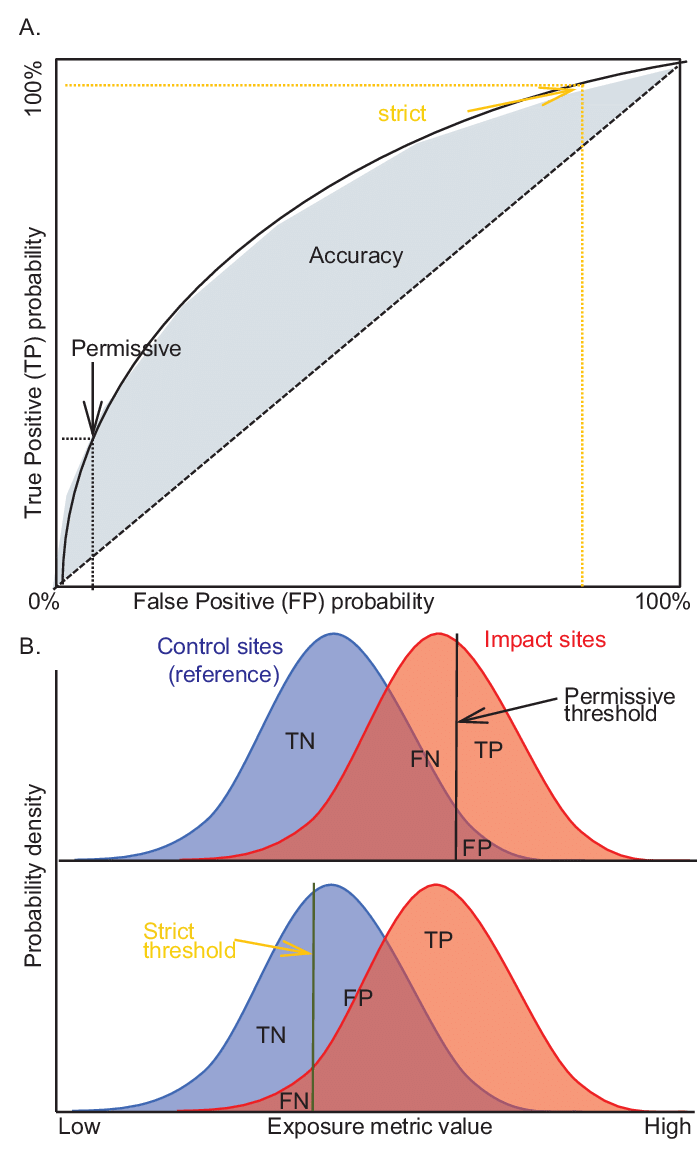

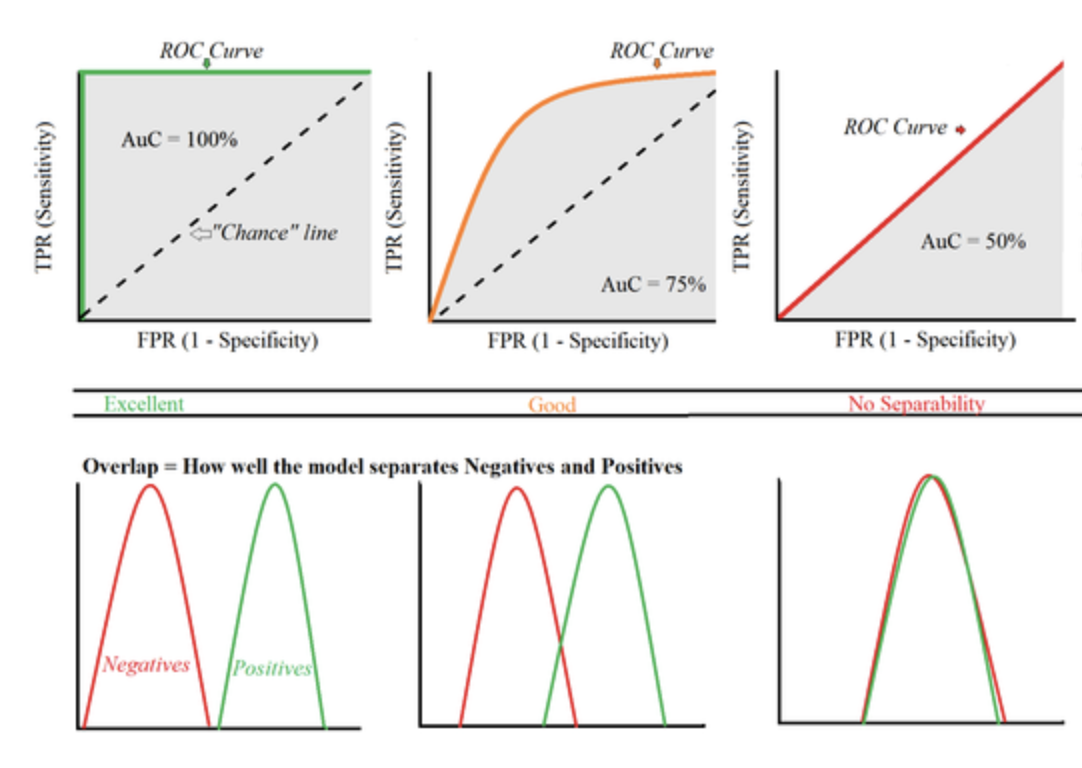

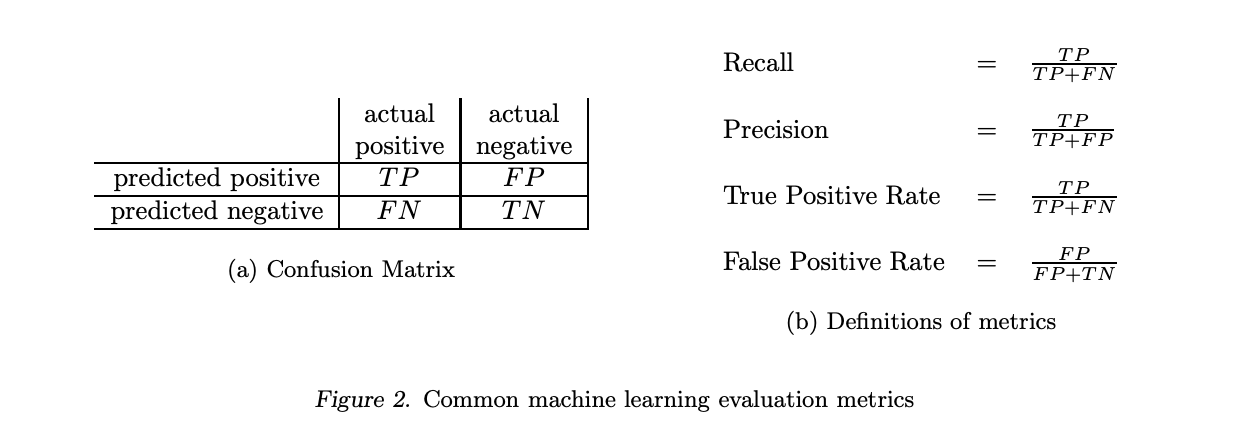

In ROC-AUC, a no skill classifier will have a score of 0.5, whereas a perfect classifier will have a score of 1.0.

The ROC Curve and ROC AUC can be optimistic under a severe class imbalance, especially when the number of examples in the minority class is small.

An alternative to the ROC Curve is the precision-recall curve that can be used in a similar way, although focuses on the performance of the classifier on the minority class. The precision of the minority class would be the focus. For a PR-AUC for a no skill is a horizental line with Presision valuecconstant at 0.5. Recall is the same as TPR and it's value can be adjusted by probability threshold to capture all the instances of a class or not. However, Precision will drop for an imbakance minority class for a classifier with a limitted performance.



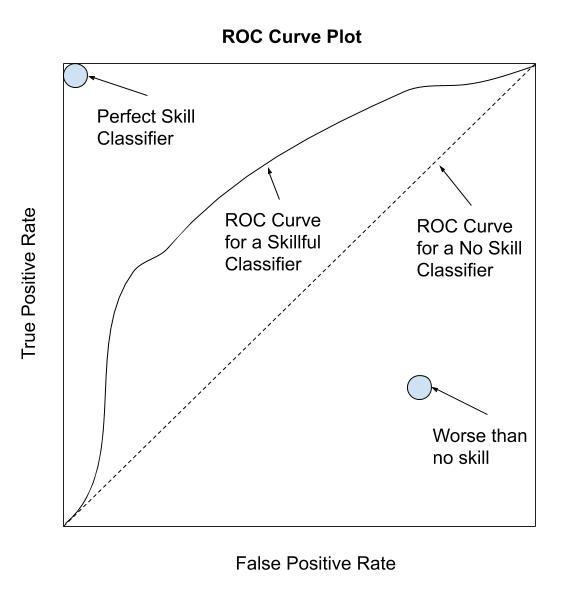

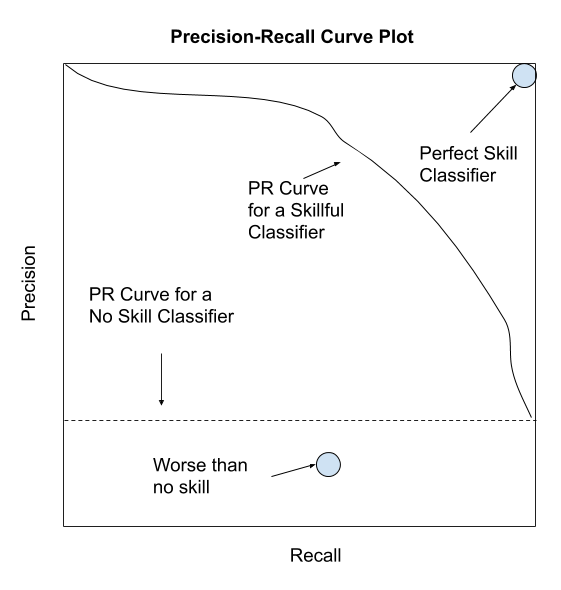

PR-AUC is 0.5 for no skill binary classifier. We can use the AUC to compare different classifiers regardless of the probability threshold.

### ROC-AUC Plot

In [194]:
# "The ROC curve is created by plotting the true positive rate (TPR) 
# against the false positive rate (FPR) 
# at various threshold settings."

# Use scikit-learn to calculate TPR & FPR at various thresholds
from sklearn.metrics import roc_curve
fpr, tpr, thresholds = roc_curve(y_val, y_pred_prob)

*roc_curve() only needs True label and binary classifier .predict_proba*

In [195]:
# See the results in a table
pd.DataFrame({
    'False Positive Rate': fpr, 
    'True Positive Rate': tpr, 
    'Threshold': thresholds
})

,False Positive Rate,True Positive Rate,Threshold
0,0.000000,0.000000,2.00
1,0.000385,0.062652,1.00
2,0.000641,0.114787,0.99
3,0.000769,0.155793,0.98
4,0.001282,0.196037,0.97
...,...,...,...
102,0.882662,0.996341,0.04
103,0.904976,0.997104,0.03
104,0.930239,0.998171,0.02
105,0.954604,0.998933,0.01


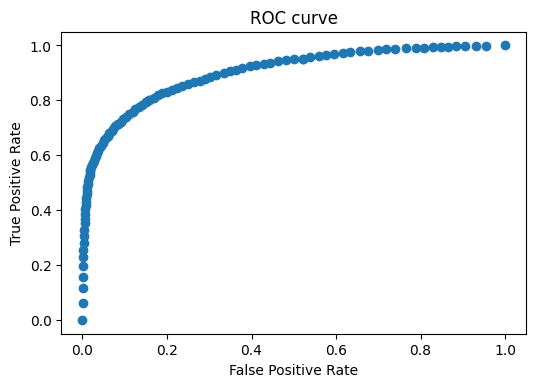

In [196]:
# See the results on a plot. 
# This is the "Receiver Operating Characteristic" curve
plt.scatter(fpr, tpr)
plt.title('ROC curve')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate');

In [198]:
# Use scikit-learn to calculate the area under the curve.
from sklearn.metrics import roc_auc_score
roc_auc_score(y_val, y_pred_prob)

0.9024268359147749

**Recap:** ROC AUC measures how well a classifier ranks predicted probabilities. So, to get the classifier’s ROC AUC score, we need to use predicted probabilities, not discrete predictions. 

Your code may look something like this:

```python
from sklearn.metrics import roc_auc_score
y_pred_proba = model.predict_proba(X_test_transformed)[:, -1] # Probability for the last class
print('Test ROC AUC:', roc_auc_score(y_test, y_pred_proba))
```

ROC AUC ranges from 0 to 1. Higher is better. A naive majority class baseline will have an ROC AUC score of 0.5.